In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind

C:\Users\User\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_csv("QVI_data.csv")

In [3]:
df.head(20)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
5,1005,2018-12-28,1,6,86,Cheetos Puffs 165g,1,2.8,165,CHEETOS,MIDAGE SINGLES/COUPLES,Mainstream
6,1007,2018-12-04,1,7,49,Infuzions SourCream&Herbs Veg Strws 110g,1,3.8,110,INFUZIONS,YOUNG SINGLES/COUPLES,Budget
7,1007,2018-12-05,1,8,10,RRD SR Slow Rst Pork Belly 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Budget
8,1009,2018-11-20,1,9,20,Doritos Cheese Supreme 330g,1,5.7,330,DORITOS,NEW FAMILIES,Premium
9,1010,2018-09-09,1,10,51,Doritos Mexicana 170g,2,8.8,170,DORITOS,YOUNG SINGLES/COUPLES,Mainstream


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


# Select Control Stores

In [5]:
def find_control_store(trial_store_id, df):
    trial_store = df[df['STORE_NBR'] == trial_store_id].groupby("DATE")["TOT_SALES"].sum().reset_index()

    # Create an empty dictionary to store similarity scores
    similarity_scores = {}

    # Loop through all stores except the trial store
    for store_id in df['STORE_NBR'].unique():
        if store_id == trial_store_id:
            continue

        control_store = df[df['STORE_NBR'] == store_id].groupby("DATE")["TOT_SALES"].sum().reset_index()

        # Merge data on DATE to ensure both stores have the same time range
        merged = pd.merge(trial_store, control_store, on="DATE", how="inner", suffixes=("_trial", "_control"))

        # Compute Pearson correlation for sales trends
        if len(merged) > 1:  # Pearson requires at least two data points
            sales_corr, _ = pearsonr(merged["TOT_SALES_trial"], merged["TOT_SALES_control"])
        else:
            sales_corr = 0  # Default to 0 correlation if insufficient data

        # Compute magnitude distance for key metrics
        magnitude_dist = 1 - (
            abs(trial_store["TOT_SALES"].mean() - control_store["TOT_SALES"].mean()) /
            (df["TOT_SALES"].max() - df["TOT_SALES"].min())
        )

        # Combine both scores (weighted sum)
        similarity_scores[store_id] = (sales_corr + magnitude_dist) / 2

    # Select the best control store based on the highest score
    best_control_store = max(similarity_scores, key=similarity_scores.get)
    
    return best_control_store, similarity_scores[best_control_store]

# Compare Trial vs Control Stores

In [6]:
def plot_trial_vs_control(trial_store_id, control_store_id, df):
    # Convert DATE column to datetime if not already
    df["DATE"] = pd.to_datetime(df["DATE"])

    # Create a 'YEAR_MONTH' column
    df["YEAR_MONTH"] = df["DATE"].dt.to_period("M")

    # Aggregate total sales by store and month
    monthly_sales = df.groupby(["STORE_NBR", "YEAR_MONTH"])["TOT_SALES"].sum().reset_index()

    # Filter data for trial and control stores
    trial_store = monthly_sales[monthly_sales["STORE_NBR"] == trial_store_id]
    control_store = monthly_sales[monthly_sales["STORE_NBR"] == control_store_id]

    # Merge to ensure aligned time series
    merged = pd.merge(trial_store, control_store, on="YEAR_MONTH", how="inner", suffixes=("_trial", "_control"))

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(merged["YEAR_MONTH"].astype(str), merged["TOT_SALES_trial"], label=f"Trial Store {trial_store_id}", marker='o')
    plt.plot(merged["YEAR_MONTH"].astype(str), merged["TOT_SALES_control"], label=f"Control Store {control_store_id}", marker='x')
    
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.title(f"Trial Store {trial_store_id} vs Control Store {control_store_id}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
def test_significance(trial_store_id, control_store_id, df):
    trial_store = df[df['STORE_NBR'] == trial_store_id]
    control_store = df[df['STORE_NBR'] == control_store_id]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(trial_store['TOT_SALES'], control_store['TOT_SALES'])
    
    return p_value

# Summarize

In [8]:
def summarize_findings(trial_store_id, control_store_id, df):
    trial_sales = df[df['STORE_NBR'] == trial_store_id]['TOT_SALES'].sum()
    control_sales = df[df['STORE_NBR'] == control_store_id]['TOT_SALES'].sum()
    p_value = test_significance(trial_store_id, control_store_id, df)

    if p_value < 0.05:
        recommendation = "Expand the trial to more stores."
    else:
        recommendation = "Trial impact was not significant. Re-evaluate the strategy."

    summary = {
        "Trial Store": trial_store_id,
        "Control Store": control_store_id,
        "Trial Total Sales": trial_sales,
        "Control Total Sales": control_sales,
        "P-Value": p_value,
        "Recommendation": recommendation
    }
    return summary

# Store 77

In [9]:
control_store_77, score_77 = find_control_store(77, df)
print(f"Control store for 77: {control_store_77}, Score: {score_77}")

Control store for 77: 14, Score: 0.5906213848553009


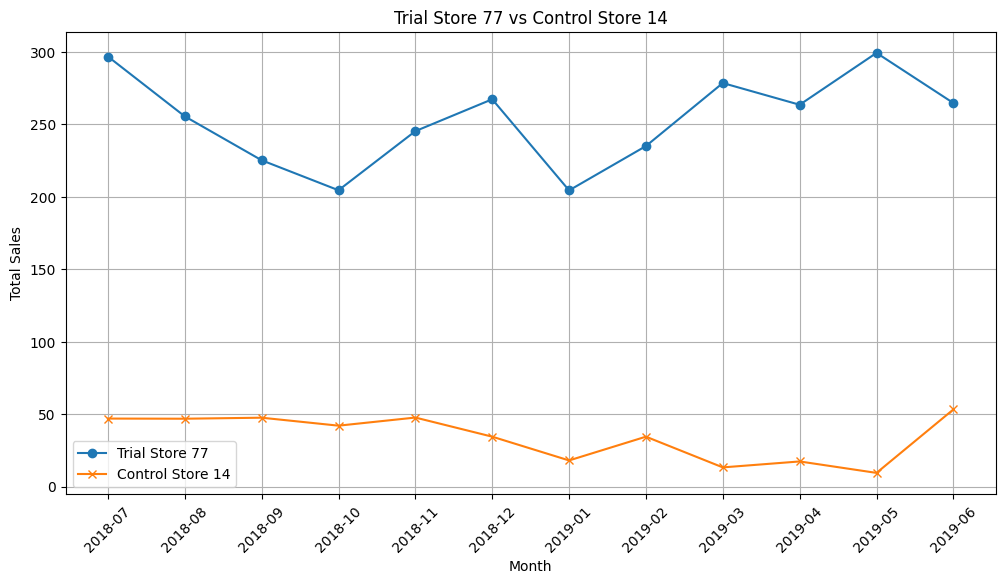

In [10]:
plot_trial_vs_control(77, control_store_77, df)

In [11]:
p_value_77 = test_significance(77, control_store_77, df)
print(f"P-value for store 77: {p_value_77}")

P-value for store 77: 0.016066900413137717


In [12]:
summary_77 = summarize_findings(77, control_store_77, df)
print(summary_77)

{'Trial Store': 77, 'Control Store': 14, 'Trial Total Sales': 3040.0, 'Control Total Sales': 410.7, 'P-Value': 0.016066900413137717, 'Recommendation': 'Expand the trial to more stores.'}


# Store 86

In [13]:
control_store_86, score_86 = find_control_store(86, df)
print(f"Control store for 86: {control_store_86}, Score: {score_86}")

C:\Users\User\AppData\Local\Temp\ipykernel_25200\407693213.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sales_corr, _ = pearsonr(merged["TOT_SALES_trial"], merged["TOT_SALES_control"])
C:\Users\User\AppData\Local\Temp\ipykernel_25200\407693213.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sales_corr, _ = pearsonr(merged["TOT_SALES_trial"], merged["TOT_SALES_control"])


Control store for 86: 85, Score: 0.5950905292479108


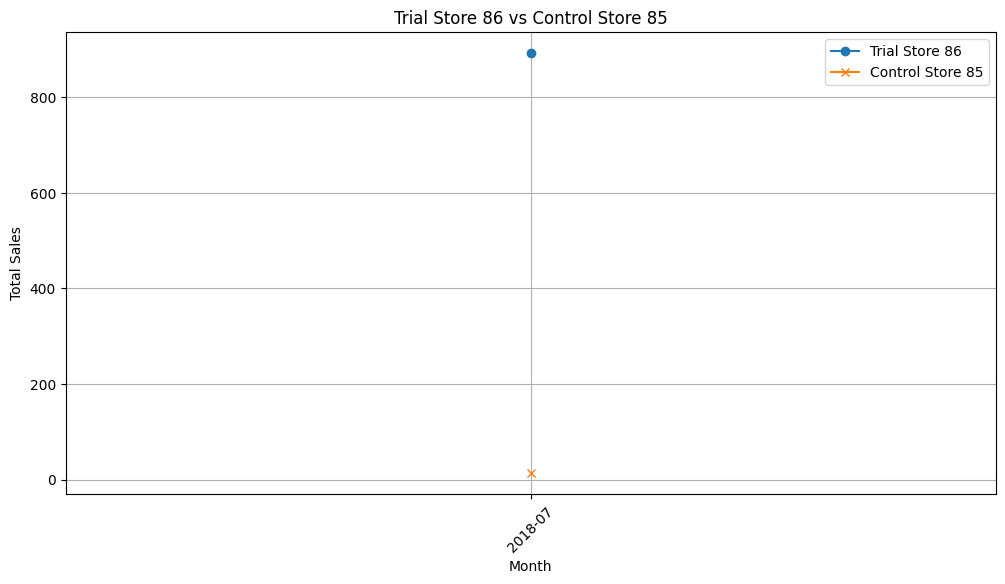

In [14]:
plot_trial_vs_control(86, control_store_86, df)

In [15]:
p_value_86 = test_significance(86, control_store_86, df)
print(f"P-value for store 86: {p_value_86}")

P-value for store 86: 0.08703687794869067


In [16]:
summary_86 = summarize_findings(86, control_store_86, df)
print(summary_86)

{'Trial Store': 86, 'Control Store': 85, 'Trial Total Sales': 10635.35, 'Control Total Sales': 13.9, 'P-Value': 0.08703687794869067, 'Recommendation': 'Trial impact was not significant. Re-evaluate the strategy.'}


# Store 88

In [17]:
control_store_88, score_88 = find_control_store(88, df)
print(f"Control store for 88: {control_store_88}, Score: {score_88}")

C:\Users\User\AppData\Local\Temp\ipykernel_25200\407693213.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sales_corr, _ = pearsonr(merged["TOT_SALES_trial"], merged["TOT_SALES_control"])
C:\Users\User\AppData\Local\Temp\ipykernel_25200\407693213.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sales_corr, _ = pearsonr(merged["TOT_SALES_trial"], merged["TOT_SALES_control"])


Control store for 88: 40, Score: 0.5344733756322766


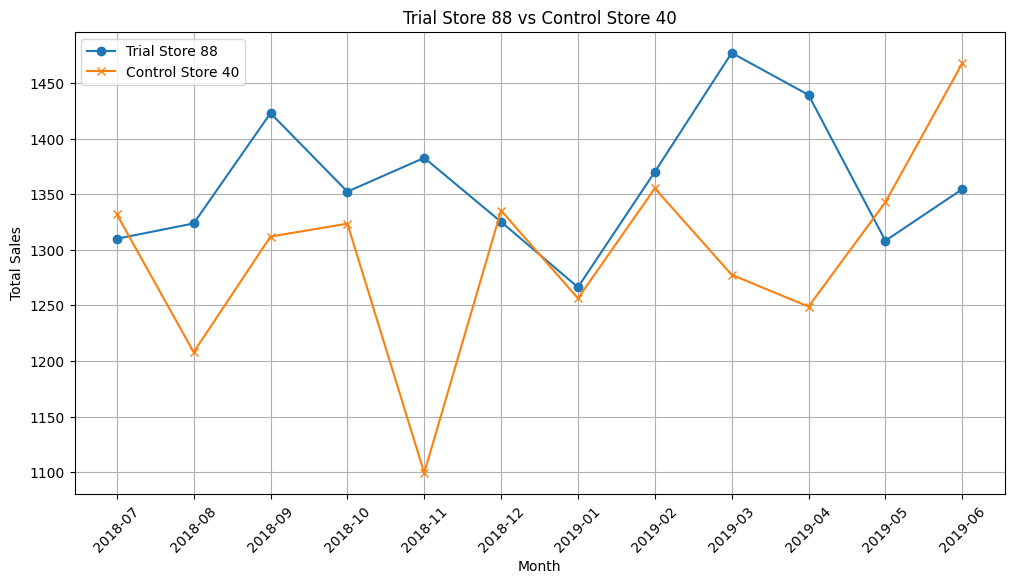

In [18]:
plot_trial_vs_control(88, control_store_88, df)

In [19]:
p_value_88 = test_significance(88, control_store_88, df)
print(f"P-value for store 88: {p_value_88}")

P-value for store 88: 0.08682733921734133


In [20]:
summary_88 = summarize_findings(88, control_store_88, df)
print(summary_88)

{'Trial Store': 88, 'Control Store': 40, 'Trial Total Sales': 16333.25, 'Control Total Sales': 15559.5, 'P-Value': 0.08682733921734133, 'Recommendation': 'Trial impact was not significant. Re-evaluate the strategy.'}
